<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Ames Housing Project

## Problem Statement

Ames Planning & Housing Department (APHD) seeks to build a predictive model that can predict the housing prices base on users' inputs. The model will be made public on the APHD website such that residents in Ames are able to (i) better understand and plan their finances before heading down to take a look at the house (saves a wasted trip) and (ii) know the current market rate to prevent potential buyers from being ripped off.


### Contents:
- [Data Import, Cleaning & Exploratory Data Analysis](#Data-Import,-Cleaning-and-Exploratory-Data-Analysis)
- [Data Modelling](#Data-Modelling)
- [Evaluation](#Evaluation)
- [Prediction](#Prediction)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

<b> Fill in background </b>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from scipy.stats import skew
import re

## Data Import, Cleaning and Exploratory Data Analysis

In [2]:
df = pd.read_csv('../datasets/train.csv')

In [3]:
df_test = pd.read_csv('../datasets/test.csv')

In [4]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

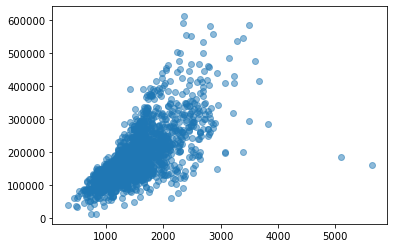

In [6]:
plt.scatter(df['Gr Liv Area'], df['SalePrice'], alpha=0.5)

As noted in the dataset documentation (http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), there are outliers in the dataset. The house is huge but sold at a relatively cheap price. We will proceed to remove these outliers.

In [7]:
df2 = df[df['Gr Liv Area']<=4000]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2049 non-null   int64  
 1   PID              2049 non-null   int64  
 2   MS SubClass      2049 non-null   int64  
 3   MS Zoning        2049 non-null   object 
 4   Lot Frontage     1719 non-null   float64
 5   Lot Area         2049 non-null   int64  
 6   Street           2049 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2049 non-null   object 
 9   Land Contour     2049 non-null   object 
 10  Utilities        2049 non-null   object 
 11  Lot Config       2049 non-null   object 
 12  Land Slope       2049 non-null   object 
 13  Neighborhood     2049 non-null   object 
 14  Condition 1      2049 non-null   object 
 15  Condition 2      2049 non-null   object 
 16  Bldg Type        2049 non-null   object 
 17  House Style   

Alley, Pool QC, Fence and Misc Feature have a lot of null values. We will be removing them from the dataset.

In [9]:
df3 = df2.drop(columns = ['Alley','Pool QC','Fence','Misc Feature'])

In [10]:
# Impute missing values with their mean
df4 = df3.fillna(df3.mean())

C:\Users\jinmi\AppData\Local\Temp/ipykernel_26328/2375268996.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df4 = df3.fillna(df3.mean())


In [11]:
df4.corr()['SalePrice'].sort_values(ascending = False).head()

SalePrice        1.000000
Overall Qual     0.803462
Gr Liv Area      0.719463
Total Bsmt SF    0.664547
Garage Area      0.655459
Name: SalePrice, dtype: float64

In [12]:
df4.corr()['SalePrice'].sort_values(ascending = True).head()

PID              -0.255068
Enclosed Porch   -0.135713
Kitchen AbvGr    -0.125472
Overall Cond     -0.097093
MS SubClass      -0.087331
Name: SalePrice, dtype: float64

Text(0.5, 1.01, 'Sale price increases as the variables increases')

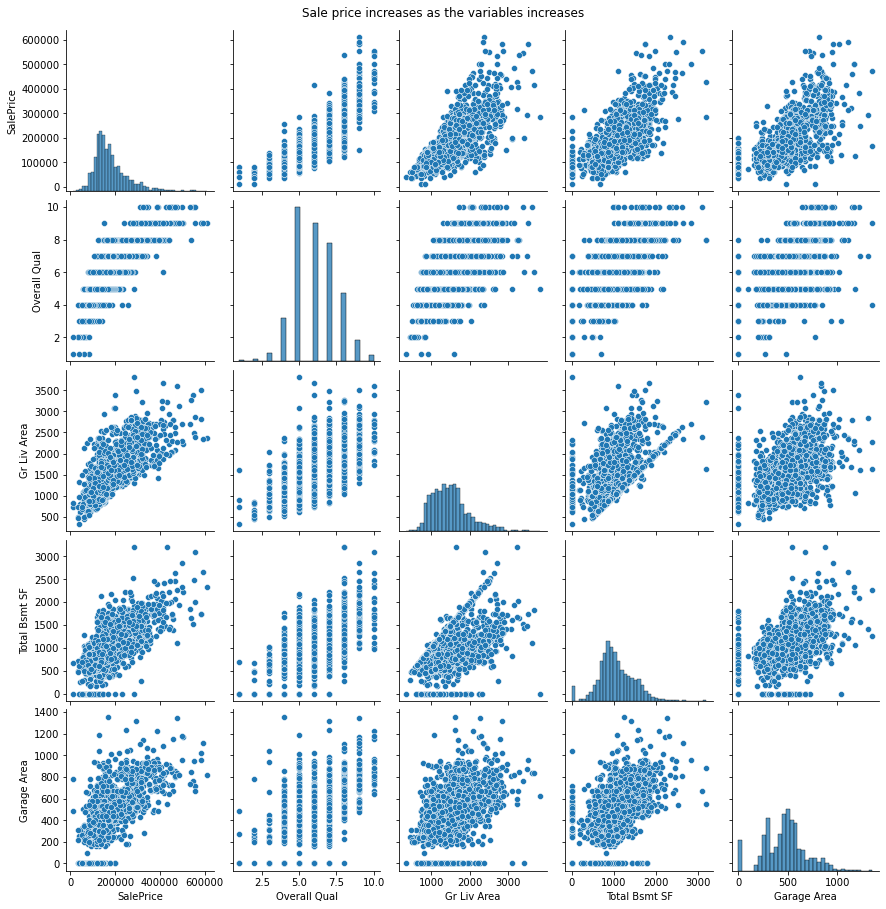

In [13]:
# Take a look at the pairplot for the top few correlated variables
columns = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area']
x = sns.pairplot(df4[columns])
x.fig.suptitle("Sale price increases as the variables increases", y = 1.01)

We also notice that many variables are right-skewed in the pairplot above. We will log transform any numeric features that are skewed (>0.5 skewness)

In [14]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2049 non-null   int64  
 1   PID              2049 non-null   int64  
 2   MS SubClass      2049 non-null   int64  
 3   MS Zoning        2049 non-null   object 
 4   Lot Frontage     2049 non-null   float64
 5   Lot Area         2049 non-null   int64  
 6   Street           2049 non-null   object 
 7   Lot Shape        2049 non-null   object 
 8   Land Contour     2049 non-null   object 
 9   Utilities        2049 non-null   object 
 10  Lot Config       2049 non-null   object 
 11  Land Slope       2049 non-null   object 
 12  Neighborhood     2049 non-null   object 
 13  Condition 1      2049 non-null   object 
 14  Condition 2      2049 non-null   object 
 15  Bldg Type        2049 non-null   object 
 16  House Style      2049 non-null   object 
 17  Overall Qual  

In [15]:
# Fillna and log transform the test submission csv too
df_test.fillna(df_test.mean(), inplace = True)
combdf = df4.append(df_test)

C:\Users\jinmi\AppData\Local\Temp/ipykernel_26328/2928344433.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_test.fillna(df_test.mean(), inplace = True)


In [16]:
#log transform skewed numeric features:
numeric_features = combdf.dtypes[combdf.dtypes != "object"].index

skewed_features = combdf[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.5]
skewed_features = skewed_features.index

combdf[skewed_features] = np.log1p(combdf[skewed_features])

In [17]:
# Convert categorical variables using get dummies
categorical_df = combdf[combdf.select_dtypes(include=['object']).columns]

In [18]:
df_dummies = pd.get_dummies(categorical_df, drop_first = True)

In [19]:
df5 = pd.concat([combdf, df_dummies], axis = 1)

In [20]:
df6 = df5.drop(columns = categorical_df)

### Data Modelling

#### 1. OLS Baseline model

In [21]:
#Separate the test submission csv from the training/testing model
df_test = df6[2049:]
df6 = df6[:2049]

In [22]:
y = df6['SalePrice']

In [23]:
x = df6.drop(columns = ['Id','SalePrice','PID'])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [25]:
base_lr = LinearRegression()
base_lr.fit(X_train,y_train)

LinearRegression()

In [26]:
r2_score_train = cross_val_score(base_lr, X_train, y_train, scoring = "r2", cv = 5).mean()
rmse_train = (-cross_val_score(base_lr, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

r2_score_test = cross_val_score(base_lr, X_test, y_test, scoring = "r2", cv = 5).mean()
rmse_test = (-cross_val_score(base_lr, X_test, y_test, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

In [27]:
print("---Baseline Model---")
print(f'R2 score on train set: {round(r2_score_train,2)}')
print(f'R2 score on test set: {round(r2_score_test,2)}')
print(f'RMSE score on train set: {round(rmse_train,2)}')
print(f'RMSE score on test set: {round(rmse_test,2)}')

---Baseline Model---
R2 score on train set: 0.9
R2 score on test set: 0.66
RMSE score on train set: 0.13
RMSE score on test set: 0.23


As the R2 score on the training set is much higher than the R2 score on the test set, the model is overfitted. We will use regularisation to penalise extreme parameter weights. Thereafter, we will compare this baseline model with the regularised models to find the best model. We will compare the scores of three different regularisation model: 
1. Ridge regularisation
2. Lasso regularisation
3. Elastic net

In [28]:
# Standardise the data

ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

#### 2. Ridge Regularisation

In [29]:
# Set up a list of ridge alphas to check.

r_alphas = np.logspace(0, 5, 100)
model_ridge = RidgeCV(alphas = r_alphas, scoring = 'neg_root_mean_squared_error', cv=5)
model_ridge.fit(Z_train, y_train)

#Estimated regularization parameter (alpha_)

alpha = model_ridge.alpha_

print("Estimated regularisation alpha:",alpha)


Estimated regularisation alpha: 236.4489412645407


In [30]:
r2_score_train = cross_val_score(model_ridge, Z_train, y_train, scoring = "r2", cv = 5).mean()
rmse_train = (-cross_val_score(model_ridge, Z_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

r2_score_test = cross_val_score(model_ridge, Z_test, y_test, scoring = "r2", cv = 5).mean()
rmse_test = (-cross_val_score(model_ridge, Z_test, y_test, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

In [31]:
print("---Ridge Regularisation---")
print(f'R2 score on train set: {round(r2_score_train,2)}')
print(f'R2 score on test set: {round(r2_score_test,2)}')
print(f'RMSE score on train set: {round(rmse_train,2)}')
print(f'RMSE score on test set: {round(rmse_test,2)}')

---Ridge Regularisation---
R2 score on train set: 0.91
R2 score on test set: 0.86
RMSE score on train set: 0.12
RMSE score on test set: 0.15


#### 3. Lasso Regularisation

In [32]:
# Set up a list of Lasso alphas to check.
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)

# Fit model using best ridge alpha!
lasso_cv.fit(Z_train, y_train);

In [33]:
# Here is the optimal value of alpha
print("Estimated regularisation alpha:",lasso_cv.alpha_)

Estimated regularisation alpha: 0.0037649358067924675


In [34]:
r2_score_train = cross_val_score(lasso_cv, Z_train, y_train, scoring = "r2", cv = 5,).mean()
rmse_train = (-cross_val_score(lasso_cv, Z_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5)).mean()
    
r2_score_test = cross_val_score(lasso_cv, Z_test, y_test, scoring = "r2", cv = 5).mean()
rmse_test = (-cross_val_score(lasso_cv, Z_test, y_test, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

In [35]:
print("---Lasso Regularisation---")
print(f'R2 score on train set: {round(r2_score_train,2)}')
print(f'R2 score on test set: {round(r2_score_test,2)}')
print(f'RMSE score on train set: {round(rmse_train,2)}')
print(f'RMSE score on test set: {round(rmse_test,2)}')

---Lasso Regularisation---
R2 score on train set: 0.91
R2 score on test set: 0.87
RMSE score on train set: 0.12
RMSE score on test set: 0.14


#### 4. Elastic Net Regularisation

In [36]:
# Set up a list of alphas to check.
enet_alphas = np.linspace(0.5, 1.0, 100)

# Set up our l1 ratio.
enet_ratio = np.arange(0.1,1,0.1)

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter = 50000)

# Fit model using optimal alpha.
enet_model = enet_model.fit(Z_train, y_train)

In [37]:
# Here is the optimal value of alpha.
enet_model.alpha_

0.5

In [38]:
r2_score_train = cross_val_score(enet_model, Z_train, y_train, scoring = "r2", cv = 5).mean()
rmse_train = (-cross_val_score(enet_model, Z_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

r2_score_test = cross_val_score(enet_model, Z_test, y_test, scoring = "r2", cv = 5).mean()
rmse_test = (-cross_val_score(enet_model, Z_test, y_test, scoring = "neg_root_mean_squared_error", cv = 5)).mean()

In [39]:
print("---Elastic Net Regularisation---")
print(f'R2 score on train set: {round(r2_score_train,2)}')
print(f'R2 score on test set: {round(r2_score_test,2)}')
print(f'RMSE score on train set: {round(rmse_train,2)}')
print(f'RMSE score on test set: {round(rmse_test,2)}')

---Elastic Net Regularisation---
R2 score on train set: 0.81
R2 score on test set: 0.78
RMSE score on train set: 0.18
RMSE score on test set: 0.19


### Evaluation

Since Lasso Regularisation has the smallest train/test RMSE out of all the models, we will use the Lasso model moving forward.

In [40]:
pred = lasso_cv.predict(Z_test)

In [41]:
residuals = y_test - pred

Text(0, 0.5, 'Residuals')

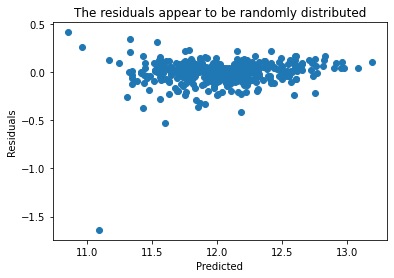

In [42]:
plt.title("The residuals appear to be randomly distributed")
plt.scatter(pred, residuals)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

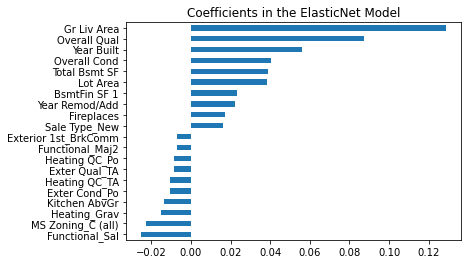

In [43]:
# Plot most and least important coefficients in the model
coef = pd.Series(lasso_cv.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [44]:
abs(coef).sort_values()

MS SubClass             0.000000
Exterior 2nd_ImStucc    0.000000
Exterior 2nd_MetalSd    0.000000
Exterior 2nd_Other      0.000000
Exterior 2nd_Plywood    0.000000
                          ...   
Total Bsmt SF           0.038972
Overall Cond            0.040181
Year Built              0.056255
Overall Qual            0.087512
Gr Liv Area             0.128475
Length: 251, dtype: float64

In [45]:
result = (lasso_cv.coef_==0)
# These are the coefficients that are > 0 and the features we are keeping
col_index = []
col_coef = []
for i in range(result.shape[0]):
    if result[i] == False: 
        col_index.append(i)
        col_coef.append(lasso_cv.coef_[i])

In [46]:
col_list = [] 
for i in col_index: #Get the column names of these features
    header = X_train.columns[i]
    col_list.append(header)

In [47]:
col_list[:5]

['Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built']

In [48]:
# Convert the coefficients back to their original units (undo the log transform)
col_coef2 = np.expm1(col_coef)

In [49]:
res = pd.DataFrame({'Feature':col_list, 'Coefficient': col_coef2})

In [50]:
res.sort_values(by = 'Coefficient', ascending = False)

,Feature,Coefficient
9,Gr Liv Area,0.137093
2,Overall Qual,0.091455
4,Year Built,0.057867
3,Overall Cond,0.040999
7,Total Bsmt SF,0.039741
...,...,...
58,Exter Cond_Po,-0.010674
12,Kitchen AbvGr,-0.013602
68,Heating_Grav,-0.015051
20,MS Zoning_C (all),-0.022681


In [51]:
res['sign'] = np.sign(res['Coefficient'])
res['sign'] = res['sign'].map({1:'positive',-1:'negative'})

In [52]:
res['abs_coef'] = abs(res['Coefficient'])

In [53]:
res.sort_values(by='abs_coef')

,Feature,Coefficient,sign,abs_coef
67,BsmtFin Type 2_GLQ,0.000062,positive,0.000062
42,Condition 1_RRAe,-0.000073,negative,0.000073
64,Bsmt Exposure_Mn,-0.000074,negative,0.000074
45,House Style_2.5Fin,0.000104,positive,0.000104
81,Fireplace Qu_Po,-0.000123,negative,0.000123
...,...,...,...,...
7,Total Bsmt SF,0.039741,positive,0.039741
3,Overall Cond,0.040999,positive,0.040999
4,Year Built,0.057867,positive,0.057867
2,Overall Qual,0.091455,positive,0.091455


In [54]:
res.sort_values(by='abs_coef')[-10:]

,Feature,Coefficient,sign,abs_coef
5,Year Remod/Add,0.022221,positive,0.022221
20,MS Zoning_C (all),-0.022681,negative,0.022681
6,BsmtFin SF 1,0.023712,positive,0.023712
78,Functional_Sal,-0.024834,negative,0.024834
1,Lot Area,0.039189,positive,0.039189
7,Total Bsmt SF,0.039741,positive,0.039741
3,Overall Cond,0.040999,positive,0.040999
4,Year Built,0.057867,positive,0.057867
2,Overall Qual,0.091455,positive,0.091455
9,Gr Liv Area,0.137093,positive,0.137093


Text(0.5, 1.0, 'Gr Liv Area increase the prices of houses in Ames the most')

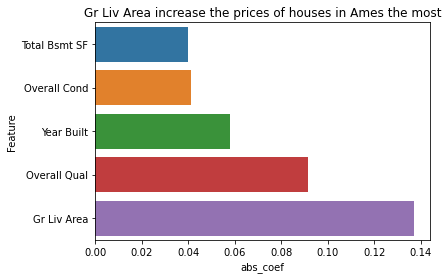

In [55]:
plot_df = res[res['sign'] == 'positive'].sort_values(by='abs_coef')[-5:]
sns.barplot(x = 'abs_coef', y = 'Feature', data = plot_df, orient = 'h')
plt.title("Gr Liv Area increase the prices of houses in Ames the most")

Text(0.5, 1.0, 'Functional_Sal decrease the prices of houses in Ames the most')

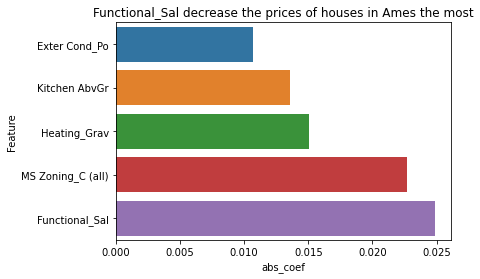

In [56]:
plot_df = res[res['sign'] == 'negative'].sort_values(by='abs_coef')[-5:]
sns.barplot(x = 'abs_coef', y = 'Feature', data = plot_df, orient = 'h')
plt.title("Functional_Sal decrease the prices of houses in Ames the most")

## Prediction

Predict values for the test.csv for submission on kaggle

In [76]:
Z_dftest = ss.transform(df_test.drop(columns = ['Id','PID','SalePrice']))
pred = lasso_cv.predict(Z_dftest)

In [78]:
pred = np.expm1(pred)

In [90]:
df_test['Id'].head()

0    2658
1    2718
2    2414
3    1989
4     625
Name: Id, dtype: int64

In [86]:
sub_df = pd.DataFrame(pred,list(df_test['Id'])).reset_index()

In [88]:
sub_df.columns = ['Id','SalePrice']

In [89]:
sub_df.head()

,Id,SalePrice
0,2658,141750.997639
1,2718,158763.403627
2,2414,224185.700799
3,1989,106850.094248
4,625,176667.426888


In [91]:
sub_df.to_csv('../datasets/submission.csv', index = False)

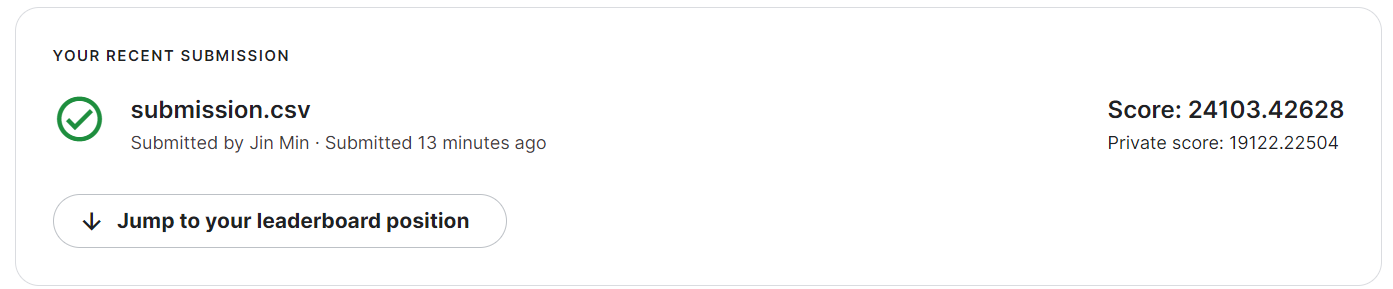

## Conclusions and Recommendations

**Conclusion:** 

The top 3 factors affecting the price of a house in Ames are: 
- Gr Liv Area: Above grade (ground) living area square feet
- Overall Qual: Rates the overall material and finish of the house
- Year Built: Original construction date

For instance, an increase in 1 sqft of Gr Liv Area will result in a ~$0.14 increase in the price of houses in Ames.

**Recommendations:**

- Potential home buyers looking for flats may reconsider looking at a house with smaller Gr Liv Area, lower Overall Qual and older Year Built if the houses are above their budget.